In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
#pip install sqlalchemy pandas (creates database)
from sqlalchemy import create_engine
import sqlite3
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score



Forcast Lead time (Lead time = Scheduled Delivery Date - PO Sent to Vendor Date)
Predict insurance price
Predict shipment/freight cost


In [129]:
#predicting shipping/freight cost 

df = pd.read_csv('supply_chain_cleaned.csv')

#Lets do some preprocessing to get the data ready for ML
df['Freight Cost (USD)'] = pd.to_numeric(df['Freight Cost (USD)'], errors='coerce')
df['Weight (Kilograms)'] = pd.to_numeric(df['Weight (Kilograms)'], errors='coerce')
df = df.dropna(subset=['Weight (Kilograms)', 'Line Item Quantity', 'Shipment Mode', 'Country', 'Freight Cost (USD)', 'Price Order', 'Sub Classification', 'Shipment Month'])

df.count()




ID                              5964
Project Code                    5964
PQ #                            5964
PO / SO #                       5964
ASN/DN #                        5964
Country                         5964
Managed By                      5964
Fulfill Via                     5964
Vendor INCO Term                5964
Shipment Mode                   5964
PQ First Sent to Client Date    5964
PO Sent to Vendor Date          5964
Scheduled Delivery Date         5964
Delivered to Client Date        5964
Delivery Recorded Date          5964
Product Group                   5964
Sub Classification              5964
Vendor                          5964
Item Description                5964
Molecule/Test Type              5964
Brand                           5964
Dosage                          4632
Dosage Form                     5964
Unit of Measure (Per Pack)      5964
Line Item Quantity              5964
Line Item Value                 5964
Pack Price                      5964
U

In [130]:
#Encode the categorical variables
for col in ['Shipment Mode', 'Country', 'Sub Classification']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

#define the features and target variable
features = ['Weight (Kilograms)', 'Country', 'Shipment Mode', 'Line Item Quantity', 'Line Item Value', 'Sub Classification','Shipment Month']

target = 'Freight Cost (USD)'

X = df[features].values
y = df[target].values

#scaling some of the feautures so we standarize the data so larger values don't dominate the model
#mean = 0 and std = 1

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(df[features])

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(df[target].values.reshape(-1, 1))

# Cap extreme freight costs at 99th percentile
cap = df[target].quantile(0.95)
df[target] = np.clip(df[target], None, cap)

#we need to make our class model now

class FreightCostModel(nn.Module):
    def __init__(self, in_features = 7, h1 =64, h2 = 32, out_features =1):
        super().__init__() #instantitates our nn.module
        self.fc1 = nn.Linear(in_features, h1) #first layer
        self.fc2 = nn.Linear(h1, h2) #second layer
        self.out = nn.Linear(h2, out_features) #output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

torch.manual_seed(42) #for reproducibility
model = FreightCostModel()

#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    #we want 20% of the data for testing, and 80% for training
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# First split into train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)
# Then split train into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

# Convert to PyTorch tensors for ML
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)


#view changes the dimensions of the tensor, we want to make sure y is at least 2 dimensions so the data is uniformed when we do calculations on it
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

train_losses = []
val_losses = []



In [131]:
#Setting the Criterion of the model, tells us how far the predictions are from the actual values
#using mean squared error loss, which is a common loss function for regression problems which this one is
criterion = nn.MSELoss()

#Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

#train our model and figuring out the epochs
epochs = 2000

#append our losses to a list so we can plot it later
losses = []

for i in range(epochs):
    # TRAINING STEP
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # VALIDATION STEP
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())

    if i % 50 == 0:
        print(f"Epoch {i}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Epoch 0, Train Loss: 0.8922, Val Loss: 0.6912
Epoch 50, Train Loss: 0.6067, Val Loss: 0.5335
Epoch 100, Train Loss: 0.5087, Val Loss: 0.4325
Epoch 150, Train Loss: 0.4320, Val Loss: 0.3593
Epoch 200, Train Loss: 0.3837, Val Loss: 0.3339
Epoch 250, Train Loss: 0.3544, Val Loss: 0.3237
Epoch 300, Train Loss: 0.3315, Val Loss: 0.3176
Epoch 350, Train Loss: 0.3116, Val Loss: 0.3110
Epoch 400, Train Loss: 0.2960, Val Loss: 0.3092
Epoch 450, Train Loss: 0.2842, Val Loss: 0.3078
Epoch 500, Train Loss: 0.2751, Val Loss: 0.3102
Epoch 550, Train Loss: 0.2675, Val Loss: 0.3115
Epoch 600, Train Loss: 0.2607, Val Loss: 0.3118
Epoch 650, Train Loss: 0.2553, Val Loss: 0.3121
Epoch 700, Train Loss: 0.2489, Val Loss: 0.3151
Epoch 750, Train Loss: 0.2438, Val Loss: 0.3175
Epoch 800, Train Loss: 0.2391, Val Loss: 0.3196
Epoch 850, Train Loss: 0.2342, Val Loss: 0.3209
Epoch 900, Train Loss: 0.2301, Val Loss: 0.3234
Epoch 950, Train Loss: 0.2268, Val Loss: 0.3265
Epoch 1000, Train Loss: 0.2231, Val Loss: 0

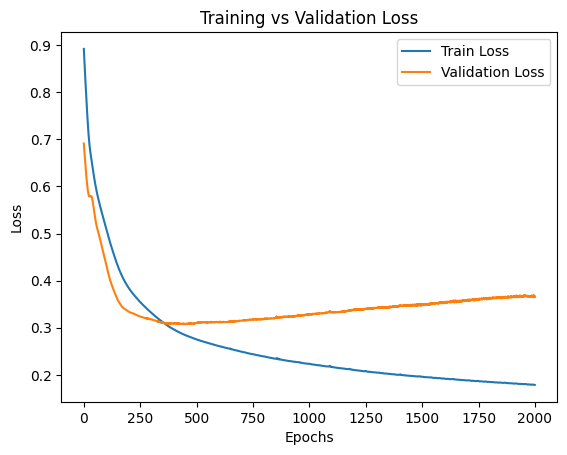

In [134]:
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [135]:
#Setting the Criterion of the model, tells us how far the predictions are from the actual values
#using mean squared error loss, which is a common loss function for regression problems which this one is
criterion = nn.MSELoss()

#Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

#train our model and figuring out the epochs
epochs = 300

#append our losses to a list so we can plot it later
losses = []

for i in range(epochs):
    
    
    #forward pass, predicts the results, passes the input data through the model
    y_pred = model.forward(X_train)
    
    #calculate loss, high at first, but should decrease as the model learns
    loss = criterion(y_pred, y_train)
    
    
    
    #append the loss to the list
    losses.append(loss.item())
    
    if i % 50 == 0:
        print(f'Epoch {i}, Loss: {loss.item()}')
              
    

    #zero the gradients, clears the old gradients, otherwise they will accumulate
    #gradients is a slope telling what direction to adjust the weights and how steeply to adjust them
    optimizer.zero_grad()

    #backward pass/back propagation, tells the model how to adjust the weights based on the loss 
    loss.backward()

    #update weights, update the model weights based on the computed gradient 
    optimizer.step()


Epoch 0, Loss: 0.17854928970336914
Epoch 50, Loss: 0.17900030314922333
Epoch 100, Loss: 0.17811590433120728
Epoch 150, Loss: 0.1778448224067688
Epoch 200, Loss: 0.17753687500953674
Epoch 250, Loss: 0.17719613015651703


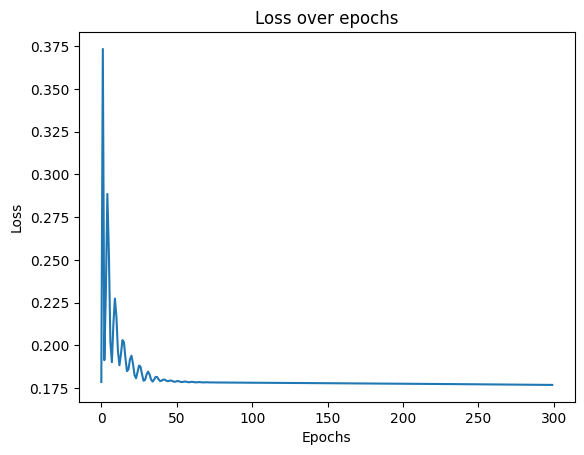

In [136]:
#graph the loss

plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.show()

In [137]:
with torch.no_grad():
    y_test_pred = model(X_test)

# Inverse transform to USD
y_test_unscaled = scaler_y.inverse_transform(y_test.numpy())
y_pred_unscaled = scaler_y.inverse_transform(y_test_pred.numpy())

# Print examples
for i in range(10):
    pred = y_pred_unscaled[i][0]
    true = y_test_unscaled[i][0]
    print(f"Example {i+1}: Predicted = ${pred:.2f}, True = ${true:.2f}")

# Compute errors
mae = np.mean(np.abs(y_pred_unscaled - y_test_unscaled))
rmse = np.sqrt(np.mean((y_pred_unscaled - y_test_unscaled)**2))
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"\nMean Absolute Error (USD): ${mae:.2f}")
print(f"Root Mean Squared Error (USD): ${rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")


Example 1: Predicted = $5431.28, True = $10942.89
Example 2: Predicted = $53157.78, True = $8654.70
Example 3: Predicted = $5005.60, True = $2220.86
Example 4: Predicted = $-1641.19, True = $584.10
Example 5: Predicted = $6306.75, True = $9601.38
Example 6: Predicted = $19079.77, True = $17214.74
Example 7: Predicted = $4110.04, True = $1746.30
Example 8: Predicted = $3393.76, True = $3980.18
Example 9: Predicted = $1915.45, True = $4861.14
Example 10: Predicted = $12800.61, True = $27804.65

Mean Absolute Error (USD): $5981.83
Root Mean Squared Error (USD): $14143.82
R^2 Score: 0.4537
